# 模糊评价和灰度预测
## Fuzzy C-Means算法

模糊c均值聚类融合了模糊理论的精髓。相较于k-means的硬聚类，模糊c提供了更加灵活的聚类结果。因为大部分情况下，数据集中的对象不能划分成为明显分离的簇，指派一个对象到一个特定的簇有些生硬，也可能会出错。故，对每个对象和每个簇赋予一个权值，指明对象属于该簇的程度。当然，基于概率的方法也可以给出这样的权值，但是有时候我们很难确定一个合适的统计模型，因此使用具有自然地、非概率特性的模糊c均值就是一个比较好的选择。

**算法步骤：**

1. 初始化：通常采用随机初始化。即权值随机地选取。簇数需要人为选定。
2. 计算质心：FCM中的质心有别于传统质心的地方在于，它是以隶属度为权重做一个加 权平均。
3. 更新模糊伪划分：即更新权重（隶属度）。简单来说，如果x越靠近质心，则隶属度越高， 反之越低。

**iris数据集**

In [1]:
import copy
import math
import random
import time
import sys
import numpy as np
import pandas as pd
from utils.grey_forecast import GrayForecast
from utils.GM import GM

sys.path.insert(0, '/Users/Bureaux/Documents/workspace/PyCharmProjects/Modeling')
from utils.c_means_cluster import c_means_fuzzy

global MAX  # 用于初始化隶属度矩阵U
MAX = 10000.0

global Epsilon  # 结束条件
Epsilon = 0.0000001

In [2]:
def import_data_format_iris(file):
    """
    file这里是输入文件的路径，如iris.txt.
    格式化数据，前四列为data，最后一列为类标号（有0，1，2三类）
    如果是你自己的data，就不需要执行此段函数了。
    """
    data = []
    cluster_location = []
    with open(str(file), 'r') as f:
        for line in f:
            current = line.strip().split(",")  #对每一行以逗号为分割，返回一个list
            current_dummy = []
            for j in range(0, len(current) - 1):
                current_dummy.append(float(current[j]))  #current_dummy存放data

            #下面注这段话提供了一个范例：若类标号不是0，1，2之类数字时该怎么给数据集
            j += 1
            if current[j] == "Iris-setosa":
                cluster_location.append(0)
            elif current[j] == "Iris-versicolor":
                cluster_location.append(1)
            else:
                cluster_location.append(2)
            data.append(current_dummy)
    # print(cluster_location)
    print("加载数据完毕")
    return data


#	return data , cluster_location

def randomize_data(data):
    """
    该功能将数据随机化，并保持随机化顺序的记录
    """
    order = list(range(0, len(data)))
    random.shuffle(order)
    new_data = [[] for i in range(0, len(data))]
    for index in range(0, len(order)):
        new_data[index] = data[order[index]]
    return new_data, order


def de_randomise_data(data, order):
    """
    此函数将返回数据的原始顺序，将randomise_data()返回的order列表作为参数
    """
    new_data = [[] for i in range(0, len(data))]
    for index in range(len(order)):
        new_data[order[index]] = data[index]
    return new_data


def print_matrix(list):
    """
    以可重复的方式打印矩阵
    """
    for i in range(0, len(list)):
        print(list[i])


def initialize_U(data, cluster_number):
    """
    这个函数是隶属度矩阵U的每行加起来都为1. 此处需要一个全局变量MAX.
    """
    global MAX
    U = []
    for i in range(0, len(data)):
        current = []
        rand_sum = 0.0
        for j in range(0, cluster_number):
            dummy = random.randint(1, int(MAX))
            current.append(dummy)
            rand_sum += dummy
        for j in range(0, cluster_number):
            current[j] = current[j] / rand_sum
        U.append(current)
    return U


def distance(point, center):
    """
    该函数计算2点之间的距离（作为列表）。我们指欧几里德距离。闵可夫斯基距离
    """
    if len(point) != len(center):
        return -1
    dummy = 0.0
    for i in range(0, len(point)):
        dummy += abs(point[i] - center[i]) ** 2
    return math.sqrt(dummy)


def end_conditon(U, U_old):
    """
	结束条件。当U矩阵随着连续迭代停止变化时，触发结束
	"""
    global Epsilon
    for i in range(0, len(U)):
        for j in range(0, len(U[0])):
            if abs(U[i][j] - U_old[i][j]) > Epsilon:
                return False
    return True


def normalise_U(U):
    """
    在聚类结束时使U模糊化。每个样本的隶属度最大的为1，其余为0
    """
    for i in range(0, len(U)):
        maximum = max(U[i])
        for j in range(0, len(U[0])):
            if U[i][j] != maximum:
                U[i][j] = 0
            else:
                U[i][j] = 1
    return U


# m的最佳取值范围为[1.5，2.5]
def fuzzy(data, cluster_number, m):
    """
    这是主函数，它将计算所需的聚类中心，并返回最终的归一化隶属矩阵U.
    参数是：簇数(cluster_number)和隶属度的因子(m)
    """
    # 初始化隶属度矩阵U
    U = initialize_U(data, cluster_number)
    # print_matrix(U)
    # 循环更新U
    while (True):
        # 创建它的副本，以检查结束条件
        U_old = copy.deepcopy(U)
        # 计算聚类中心
        C = []
        for j in range(0, cluster_number):
            current_cluster_center = []
            for i in range(0, len(data[0])):
                dummy_sum_num = 0.0
                dummy_sum_dum = 0.0
                for k in range(0, len(data)):
                    # 分子
                    dummy_sum_num += (U[k][j] ** m) * data[k][i]
                    # 分母
                    dummy_sum_dum += (U[k][j] ** m)
                # 第i列的聚类中心
                current_cluster_center.append(dummy_sum_num / dummy_sum_dum)
            # 第j簇的所有聚类中心
            C.append(current_cluster_center)

        # 创建一个距离向量, 用于计算U矩阵。
        distance_matrix = []
        for i in range(0, len(data)):
            current = []
            for j in range(0, cluster_number):
                current.append(distance(data[i], C[j]))
            distance_matrix.append(current)

        # 更新U
        for j in range(0, cluster_number):
            for i in range(0, len(data)):
                dummy = 0.0
                for k in range(0, cluster_number):
                    # 分母
                    dummy += (distance_matrix[i][j] / distance_matrix[i][k]) ** (2 / (m - 1))
                U[i][j] = 1 / dummy

        if end_conditon(U, U_old):
            print("结束聚类")
            break
    print("标准化 U")
    U = normalise_U(U)
    return U


def checker_iris(final_location):
    """
    和真实的聚类结果进行校验比对
    """
    right = 0.0
    for k in range(0, 3):
        checker = [0, 0, 0]
        for i in range(0, 50):
            for j in range(0, len(final_location[0])):
                if final_location[i + (50 * k)][j] == 1:  #i+(50*k)表示 j表示第j类
                    checker[j] += 1  #checker分别统计每一类分类正确的个数
        right += max(checker)  #累加分类正确的个数
        print(checker)
    print('分类正确的个数是:', right)
    answer = right / 150 * 100
    return "准确率：" + str(answer) + "%"

In [3]:
# 加载数据
data = import_data_format_iris("../data/iris.txt")
# print_matrix(data)

# 随机化数据
data, order = randomize_data(data)
# print_matrix(data)

start = time.time()
# 现在我们有一个名为data的列表，它只是数字
# 我们还有另一个名为cluster_location的列表，它给出了正确的聚类结果位置
# 调用模糊C均值函数
final_location = fuzzy(data, 3, 2)

# 还原数据
final_location = de_randomise_data(final_location, order)
#	print_matrix(final_location)

# 准确度分析
print(checker_iris(final_location))
print("用时：{0}".format(time.time() - start))

加载数据完毕
结束聚类
标准化 U
[0, 50, 0]
[47, 0, 3]
[13, 0, 37]
分类正确的个数是: 134.0
准确率：89.33333333333333%
用时：0.1251072883605957


**自己的数据集**

In [4]:
data = [[6.1, 2.8, 4.7, 1.2], [5.1, 3.4, 1.5, 0.2], [6.0, 3.4, 4.5, 1.6], [4.6, 3.1, 1.5, 0.2],
        [6.7, 3.3, 5.7, 2.1], [7.2, 3.0, 5.8, 1.6], [6.7, 3.1, 4.4, 1.4], [6.4, 2.7, 5.3, 1.9],
        [4.8, 3.0, 1.4, 0.3], [7.9, 3.8, 6.4, 2.0], [5.2, 3.5, 1.5, 0.2], [5.9, 3.0, 5.1, 1.8],
        [5.7, 2.8, 4.1, 1.3], [6.8, 3.2, 5.9, 2.3], [5.4, 3.4, 1.5, 0.4], [5.4, 3.7, 1.5, 0.2],
        [6.6, 3.0, 4.4, 1.4], [5.1, 3.5, 1.4, 0.2], [6.0, 2.2, 4.0, 1.0], [7.7, 2.8, 6.7, 2.0],
        [6.3, 2.8, 5.1, 1.5], [7.4, 2.8, 6.1, 1.9], [5.5, 4.2, 1.4, 0.2], [5.7, 3.0, 4.2, 1.2],
        [5.5, 2.6, 4.4, 1.2], [5.2, 3.4, 1.4, 0.2], [4.9, 3.1, 1.5, 0.1], [4.6, 3.6, 1.0, 0.2],
        [4.6, 3.2, 1.4, 0.2], [5.8, 2.7, 3.9, 1.2], [5.0, 3.4, 1.5, 0.2], [6.1, 3.0, 4.6, 1.4],
        [4.7, 3.2, 1.6, 0.2], [6.7, 3.3, 5.7, 2.5], [6.5, 3.0, 5.8, 2.2], [5.4, 3.4, 1.7, 0.2],
        [5.8, 2.7, 5.1, 1.9], [5.4, 3.9, 1.3, 0.4], [5.3, 3.7, 1.5, 0.2], [6.1, 3.0, 4.9, 1.8],
        [7.2, 3.2, 6.0, 1.8], [5.5, 2.3, 4.0, 1.3], [5.7, 2.8, 4.5, 1.3], [4.9, 2.4, 3.3, 1.0],
        [5.4, 3.0, 4.5, 1.5], [5.0, 3.5, 1.6, 0.6], [5.2, 4.1, 1.5, 0.1], [5.8, 4.0, 1.2, 0.2],
        [5.4, 3.9, 1.7, 0.4], [6.5, 3.2, 5.1, 2.0], [5.5, 2.4, 3.7, 1.0], [5.0, 3.5, 1.3, 0.3],
        [6.3, 2.5, 5.0, 1.9], [6.9, 3.1, 4.9, 1.5], [6.2, 2.2, 4.5, 1.5], [6.3, 3.3, 4.7, 1.6],
        [6.4, 3.2, 4.5, 1.5], [4.7, 3.2, 1.3, 0.2], [5.5, 2.4, 3.8, 1.1], [5.0, 2.0, 3.5, 1.0],
        [4.4, 2.9, 1.4, 0.2], [4.8, 3.4, 1.9, 0.2], [6.3, 3.4, 5.6, 2.4], [5.5, 2.5, 4.0, 1.3],
        [5.7, 2.5, 5.0, 2.0], [6.5, 3.0, 5.2, 2.0], [6.7, 3.0, 5.0, 1.7], [5.2, 2.7, 3.9, 1.4],
        [6.9, 3.1, 5.1, 2.3], [7.2, 3.6, 6.1, 2.5], [4.8, 3.0, 1.4, 0.1], [6.3, 2.9, 5.6, 1.8],
        [5.1, 3.5, 1.4, 0.3], [6.9, 3.1, 5.4, 2.1], [5.6, 3.0, 4.1, 1.3], [7.7, 2.6, 6.9, 2.3],
        [6.4, 2.9, 4.3, 1.3], [5.8, 2.7, 4.1, 1.0], [6.1, 2.9, 4.7, 1.4], [5.7, 2.9, 4.2, 1.3],
        [6.2, 2.8, 4.8, 1.8], [4.8, 3.4, 1.6, 0.2], [5.6, 2.9, 3.6, 1.3], [6.7, 2.5, 5.8, 1.8],
        [5.0, 3.4, 1.6, 0.4], [6.3, 3.3, 6.0, 2.5], [5.1, 3.8, 1.9, 0.4], [6.6, 2.9, 4.6, 1.3],
        [5.1, 3.3, 1.7, 0.5], [6.3, 2.5, 4.9, 1.5], [6.4, 3.1, 5.5, 1.8], [6.2, 3.4, 5.4, 2.3],
        [6.7, 3.1, 5.6, 2.4], [4.6, 3.4, 1.4, 0.3], [5.5, 3.5, 1.3, 0.2], [5.6, 2.7, 4.2, 1.3],
        [5.6, 2.8, 4.9, 2.0], [6.2, 2.9, 4.3, 1.3], [7.0, 3.2, 4.7, 1.4], [5.0, 3.2, 1.2, 0.2],
        [4.3, 3.0, 1.1, 0.1], [7.7, 3.8, 6.7, 2.2], [5.6, 3.0, 4.5, 1.5], [5.8, 2.7, 5.1, 1.9],
        [5.8, 2.8, 5.1, 2.4], [4.9, 3.1, 1.5, 0.1], [5.7, 3.8, 1.7, 0.3], [7.1, 3.0, 5.9, 2.1],
        [5.1, 3.7, 1.5, 0.4], [6.3, 2.7, 4.9, 1.8], [6.7, 3.0, 5.2, 2.3], [5.1, 2.5, 3.0, 1.1],
        [7.6, 3.0, 6.6, 2.1], [4.5, 2.3, 1.3, 0.3], [4.9, 3.0, 1.4, 0.2], [6.5, 2.8, 4.6, 1.5],
        [5.7, 4.4, 1.5, 0.4], [6.8, 3.0, 5.5, 2.1], [4.9, 2.5, 4.5, 1.7], [5.1, 3.8, 1.5, 0.3],
        [6.5, 3.0, 5.5, 1.8], [5.7, 2.6, 3.5, 1.0], [5.1, 3.8, 1.6, 0.2], [5.9, 3.0, 4.2, 1.5],
        [6.4, 3.2, 5.3, 2.3], [4.4, 3.0, 1.3, 0.2], [6.1, 2.8, 4.0, 1.3], [6.3, 2.3, 4.4, 1.3],
        [5.0, 2.3, 3.3, 1.0], [5.0, 3.6, 1.4, 0.2], [5.9, 3.2, 4.8, 1.8], [6.4, 2.8, 5.6, 2.2],
        [6.1, 2.6, 5.6, 1.4], [5.6, 2.5, 3.9, 1.1], [6.0, 2.7, 5.1, 1.6], [6.0, 3.0, 4.8, 1.8],
        [6.4, 2.8, 5.6, 2.1], [6.0, 2.9, 4.5, 1.5], [5.8, 2.6, 4.0, 1.2], [7.7, 3.0, 6.1, 2.3],
        [5.0, 3.3, 1.4, 0.2], [6.9, 3.2, 5.7, 2.3], [6.8, 2.8, 4.8, 1.4], [4.8, 3.1, 1.6, 0.2],
        [6.7, 3.1, 4.7, 1.5], [4.9, 3.1, 1.5, 0.1], [7.3, 2.9, 6.3, 1.8], [4.4, 3.2, 1.3, 0.2],
        [6.0, 2.2, 5.0, 1.5], [5.0, 3.0, 1.6, 0.2]]
start = time.time()

# 调用模糊C均值函数
res_U = c_means_fuzzy(data, 3, 2)
np_U = np.array(res_U)
print(np_U.argmax(axis=1))

# 计算准确率
print("用时：{0}".format(time.time() - start))

已完成聚类
[2 0 2 0 1 1 2 1 0 1 0 2 2 1 0 0 2 0 2 1 2 1 0 2 2 0 0 0 0 2 0 2 0 1 1 0 2
 0 0 2 1 2 2 2 2 0 0 0 0 1 2 0 2 1 2 2 2 0 2 2 0 0 1 2 2 1 1 2 1 1 0 1 0 1
 2 1 2 2 2 2 2 0 2 1 0 1 0 2 0 2 1 1 1 0 0 2 2 2 1 0 0 1 2 2 1 0 0 1 0 2 1
 2 1 0 0 2 0 1 2 0 1 2 0 2 1 0 2 2 2 0 2 1 1 2 2 2 1 2 2 1 0 1 2 0 2 0 1 0
 2 0]
用时：0.1441810131072998


## 模糊理论
模糊控制是自动化控制领域的一项经典方法。其原理则是模糊数学、模糊逻辑。1965，L. A. Zadeh发表模糊集合“Fuzzy Sets”的论文， 首次引入隶属度函数的概念，打破了经典数学“非0即 1”的局限性，用[0,1]之间的实数来描述中间状态。

很多经典的集合（即：论域U内的某个元素是否属于集合A，可以用一个数值来表示。在经典集合中，要么0，要么1）不能描述很多事物的属性，需要用模糊性词语来判断。比如天气冷热程度、人的胖瘦程度等等。模糊数学和模糊逻辑把只取1或0二值（属于/不属于）的普通集合概念推广0~1区间内的多个取值，即隶属度。用“隶属度”来描述元素和集合之间的关系。

<img src="../images/iShot2021-09-02 11.29.20.png"/>

如图所示，对于冷热程度，我们采取三个模糊子集：冷、暖、热。对于某一个温度，可能同时属于两个子集。要进一步具体判断，我们就需要提供一个描述“程度”的函数，即隶属度。

例如，身高可以分为“高”、“中等”、“矮”三个子集。取论域U（即人的身高范围）为[1.0,3.0]，单位m。在U上定义三个隶属度函数来确定身高与三个模糊子集的关系：

<img src="../images/iShot2021-09-02 11.29.45.png"/>

**模糊规则的设定**:

1. 专家的经验和知识：藉由询问经验丰富的专家，在获得系统的知 识后，将知识改为IF....THEN ....的型式。
2. 操作员的操作模式：记录熟练的操作员的操作模式，并将其整理为IF....THEN ....的型式。
3. 自学习：设定的模糊规则可能存在偏差，模糊控制器能依设定的目标，增加或修改模糊控制规则

## 灰色预测
灰色预测是用灰色模型GM(1,1)来进行定量分析的，通常分为以下几类：
1. 灰色时间序列预测。用等时距观测到的反映预测对象特征的一系列数量（如产量、销量、人口数量、存款数量、利率等）构造灰色预测模型，预测未来某一时刻的特征量，或者达到某特征量的时间。
2. 畸变预测（灾变预测）。通过模型预测异常值出现的时刻，预测异常值什么时候出现在特定时区内。
3. 波形预测，或称为拓扑预测，它是通过灰色模型预测事物未来变动的轨迹。
4. 系统预测，对系统行为特征指标建立一族相互关联的灰色预测理论模型，在预测系统整体变化的同时，预测系统各个环节的变化。

上述灰色预测方法的共同特点是：
1. 允许少数据预测；
2. 允许对灰因果律事件进行预测，例如：
    - 灰因白果律事件：在粮食生产预测中，影响粮食生产的因子很多，多到无法枚举，故为灰因，然而粮食产量却是具体的，故为白果。粮食预测即为灰因白果律事件预测。
    - 白因灰果律事件：在开发项目前景预测时，开发项目的投入是具体的，为白因，而项目的效益暂时不很清楚，为灰果。项目前景预测即为灰因白果律事件预测。
3. 具有可检验性，包括：建模可行性的级比检验（事前检验），建模精度检验（模型检验），预测的滚动检验（预测检验）。

[参考](https://www.jianshu.com/p/a35ba96d852b)

              票房
0      33.270000
1      43.410000
2      62.060000
3     101.720000
4     131.150000
5     170.730000
6     217.690000
7     296.390000
8     440.690000
9     457.120000
10    559.110000
11    671.137260
12    767.241838
13    916.470795
14   1069.425960
15   1248.267607
16   1463.742026
17   1703.568377
18   1985.318549
19   2309.710701
20   2681.025525
21   3110.165295
22   3601.693843
23   4165.460217
24   4811.731411
25   5550.566957
26   6395.188903
27   7359.305386
28   8458.509103
29   9710.663940
30  11135.323835
31  12754.669406
32  14593.471262
33  16679.331607
34  19043.200612
35  21719.556307
36  24746.865329
37  28168.021037
38  32030.763030
39  36388.233771
40  41299.525105


/Users/Bureaux/miniconda3/envs/Torch-base/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 31080 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Bureaux/miniconda3/envs/Torch-base/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Bureaux/miniconda3/envs/Torch-base/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 31080 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/Bureaux/miniconda3/envs/Torch-base/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 25151 missing from current font.
  font.set_text(s, 0, flags=flags)


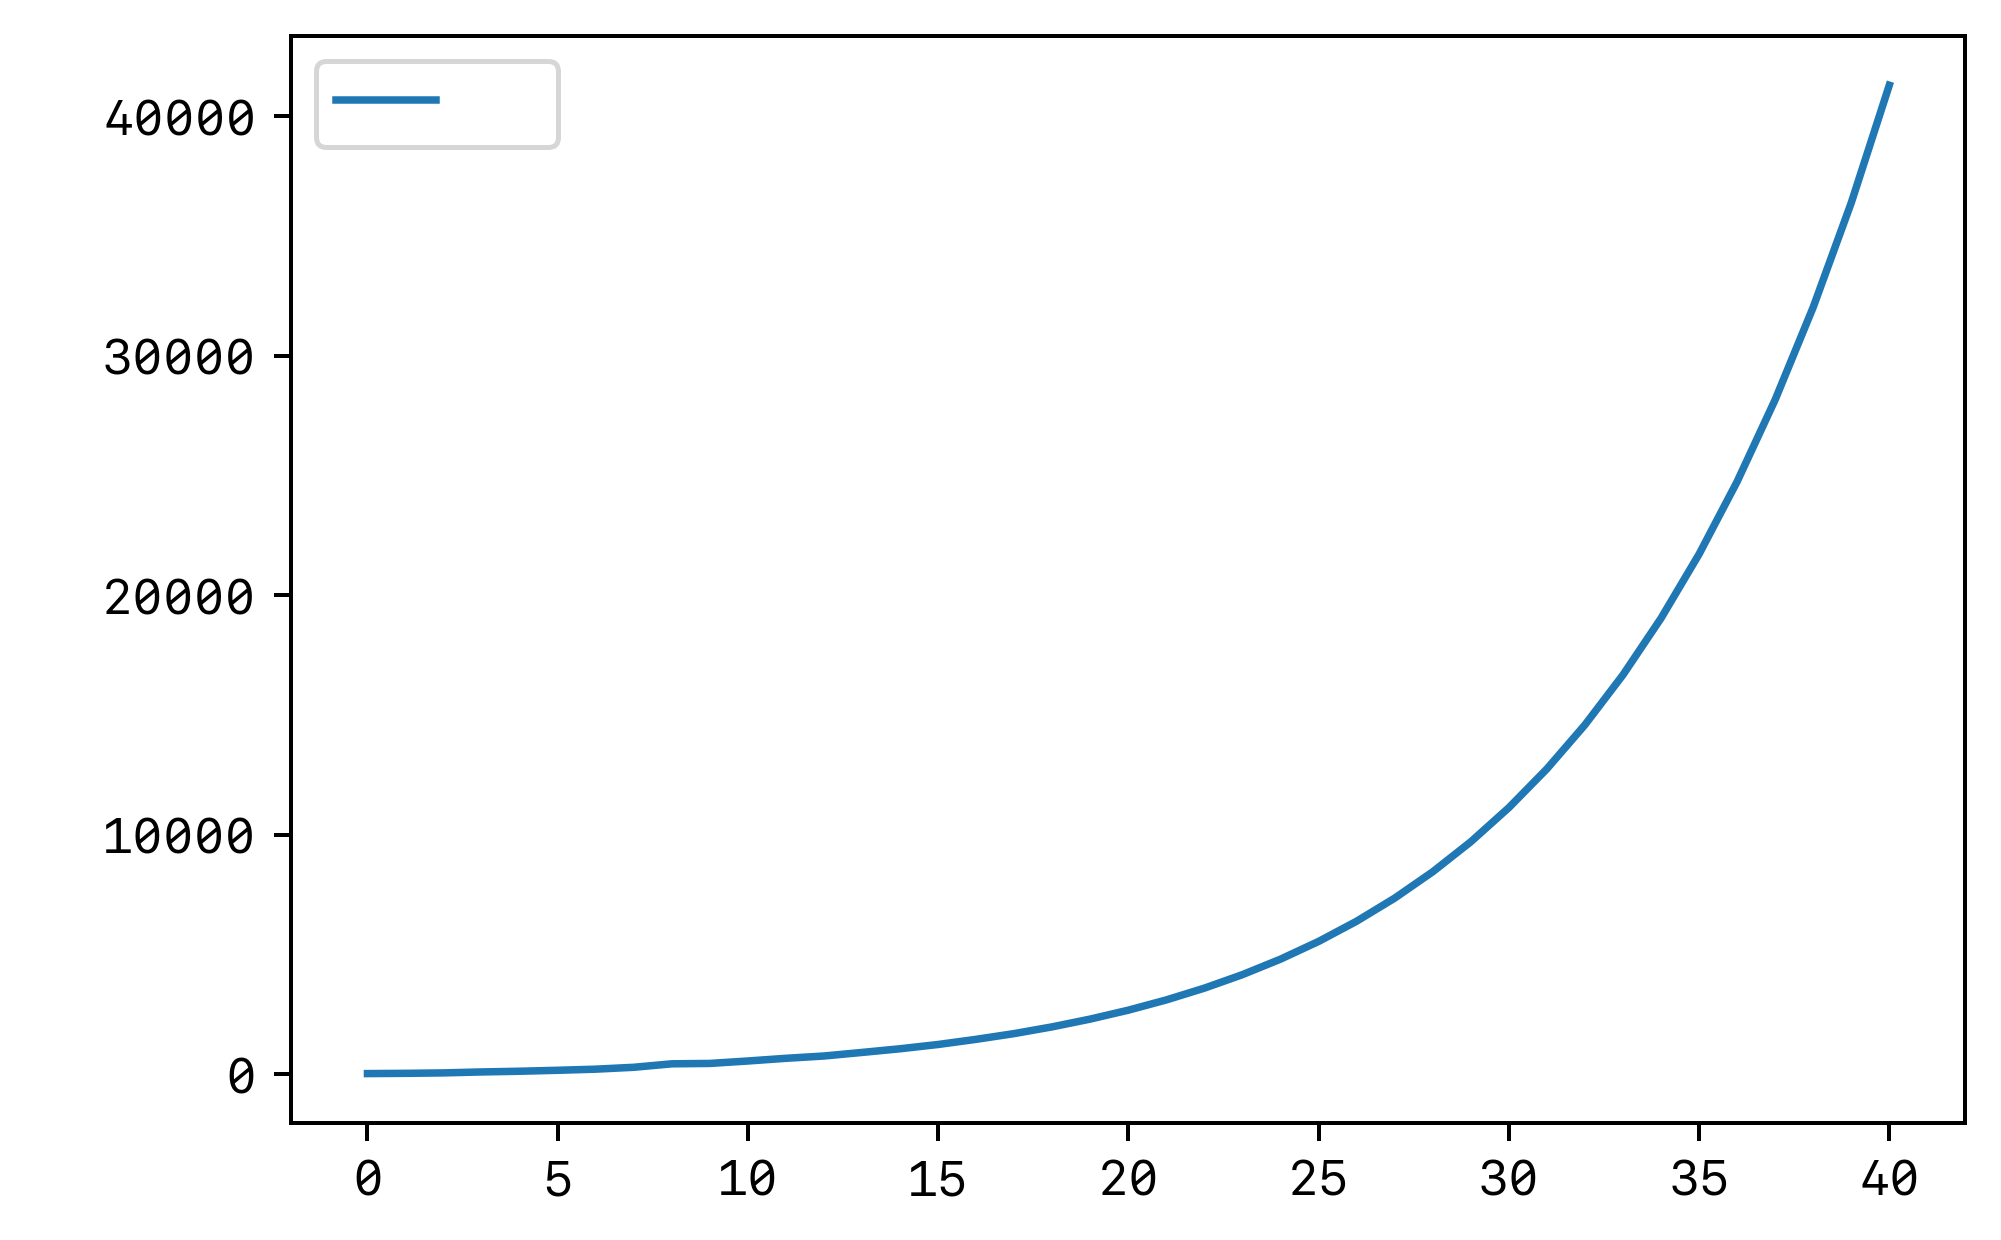

In [5]:
f = open("../data/电影票房.csv", encoding="utf8")
df = pd.read_csv(f)
df.tail()
gf = GrayForecast(df, '票房')
gf.forecast(30)
print(gf.log())
gf.plot()

In [6]:
ls = list(range(91, 120, 2))
gm = GM()
gm.fit(ls)
print(gm.confidence())
print(gm.predict(m=2))
print('-------------------------')
c = {"data": ls}  #将列表a，b转换成字典
data = pd.core.frame.DataFrame(c)  #将字典转换成为数据框
gf = GrayForecast(data, 'data')
gf.forecast(2)
print(gf.log())

0.0021
[91.0, 93.5068, 95.2858, 97.0986, 98.9459, 100.8284, 102.7467, 104.7014, 106.6934, 108.7232, 110.7917, 112.8996, 115.0475, 117.2363, 119.4667, 121.7396, 124.0557]
-------------------------
         data
0    91.00000
1    93.00000
2    95.00000
3    97.00000
4    99.00000
5   101.00000
6   103.00000
7   105.00000
8   107.00000
9   109.00000
10  111.00000
11  113.00000
12  115.00000
13  117.00000
14  119.00000
15  121.08342
16  123.16821
